In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw # Added for molecule visualization
from rdkit import RDLogger
from rdkit.Chem import Crippen, Descriptors, MolToSmiles, Draw, QED, rdMolDescriptors
try:
    from rdkit.Chem.SA_Score import sascorer
except ImportError:
    from rdkit.Contrib.SA_Score import sascorer
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split #ML training

RDLogger.DisableLog('rdApp.*') 

In [2]:
from simple_ga import simple_genetic_algorithm, generate_random_smiles, plot_ga_results

In [3]:
# --- Notes for the user ---
# 1. Fitness Function: The `example_fitness_function` is very basic.
#    For real molecular design, use RDKit or other cheminformatics toolkits to:
#    a. Validate SMILES: `mol = Chem.MolFromSmiles(s)`. If `mol is None`, it's invalid.
#    b. Calculate properties: LogP, QED, molecular weight, presence of specific
#       functional groups, similarity to a target, docking scores, etc.
#    c. The fitness function MUST handle invalid SMILES gracefully (e.g., return
#       a very low score or None, as handled by the GA).
#
# 2. SMILES_CHARS: The `SMILES_CHARS` list is a simplified alphabet.
#    Tailor it to the chemical space you are exploring (e.g., add 'Si', 'B', aromatic lowercase atoms).
#
# 3. Crossover and Mutation: These are simple string manipulations and will
#    often produce invalid SMILES. The fitness function's ability to
#    penalize/filter invalid SMILES is crucial. More advanced, chemically-aware
#    operators exist (e.g., using SELFIES, graph-based methods) but are more complex.
#

In [4]:
# --- User-defined components ---
def example_fitness_function(smiles_string):
    """
    A placeholder fitness function. Scores based on length and presence of 'O'.
    A real fitness function should use cheminformatics toolkits (e.g., RDKit)
    for SMILES validation and property calculation.
    It MUST handle potentially invalid SMILES (e.g., return a very low score or None).
    """
    if not smiles_string: # Handle empty string
        return -1000.0 

    # Using RDKit for validation
    mol = Chem.MolFromSmiles(smiles_string)
    if mol is None:
        return -1000.0  # Invalid SMILES

    score = 0.0
    # Reward length within a certain range
    if 5 <= len(smiles_string) <= 30:
        score += len(smiles_string)
    else:
        score -= abs(len(smiles_string) - 15) # Penalize deviation from ideal length 15

    score += smiles_string.count('O') * 10  # Reward Oxygen
    score += smiles_string.count('N') * 5   # Reward Nitrogen
    score -= smiles_string.count('Cl') * 2 # Penalize Chlorine slightly
    
    # Penalize if too short or too long after other calcs
    if len(smiles_string) < 3 or len(smiles_string) > 50:
        return -1000.0

    return score

In [5]:
# --- GA Parameters ---
num_generations = 100
pop_size = 100
crossover_rate = 0.8
mutation_rate = 0.2 # Probability an individual is mutated
tournament_size = 5
elitism_count = 2
initial_pop = [generate_random_smiles(random.randint(10, 25)) for _ in range(pop_size)]

Starting Simple Genetic Algorithm for SMILES generation...
Generation 1: New best -> Fitness: -1000.0000, SMILES: (Fl281C#46
Generation 2: Best this gen -> Fitness: -1000.0000, SMILES: (Fl281C#46
Generation 3: Best this gen -> Fitness: -1000.0000, SMILES: (Fl281C#46
Generation 4: New best -> Fitness: 9.0000, SMILES: ONCN
Generation 5: Best this gen -> Fitness: 9.0000, SMILES: ONCN
Generation 6: Best this gen -> Fitness: 9.0000, SMILES: ONCN
Generation 7: New best -> Fitness: 41.0000, SMILES: ONONCN
Generation 8: New best -> Fitness: 48.0000, SMILES: ONCNONCN
Generation 9: New best -> Fitness: 55.0000, SMILES: ONCNNONCCN
Generation 10: New best -> Fitness: 88.0000, SMILES: ONCNONONONNCN
Generation 11: New best -> Fitness: 118.0000, SMILES: ONONONCCNONNNONNCN
Generation 12: New best -> Fitness: 157.0000, SMILES: ONONNNONNONCNONONONNCN
Generation 13: New best -> Fitness: 215.0000, SMILES: ONONNNONNOONCONNONNONNONCN.NON
Generation 14: New best -> Fitness: 262.0000, SMILES: ONONNNONNOONCONN

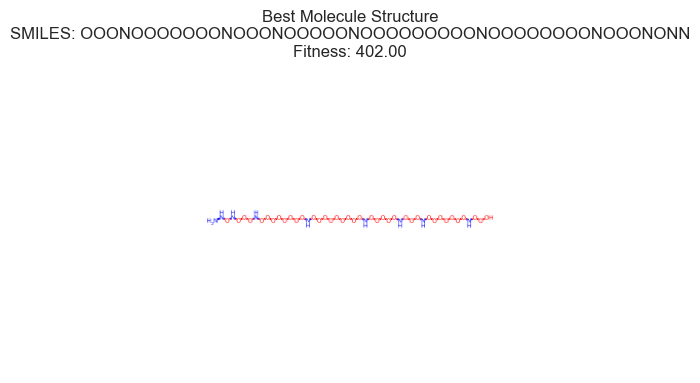

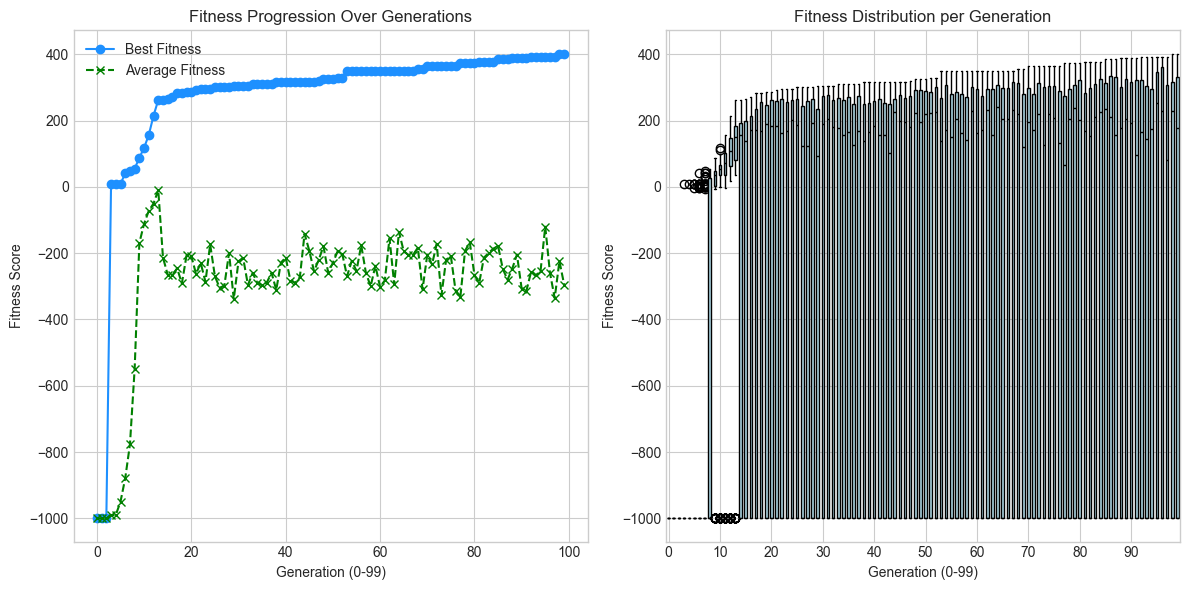

In [6]:
print("Starting Simple Genetic Algorithm for SMILES generation...")

results = simple_genetic_algorithm(
    initial_population=initial_pop,
    fitness_function=example_fitness_function,
    generations=num_generations,
    population_size=pop_size,
    crossover_rate=crossover_rate,
    mutation_rate=mutation_rate,
    tournament_size=tournament_size,
    elitism_count=elitism_count
)

print("\nGA Run Finished.")
print(f"Best SMILES found: {results['best_smiles']}")
print(f"Best Fitness score: {results['best_fitness']:.4f}")
plot_ga_results(results)

In [7]:
# Lets do a more interesting example using simple rdkit logp prediction
def rdkit_logp_fitness(smiles):
    """
    Calculates the LogP for a given SMILES string using RDKit.
    Returns a very low score for invalid SMILES.
    """
    if not smiles:
        return -1000.0 # Penalize empty SMILES

    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return -1000.0  # Invalid SMILES, return a very low fitness
    try:
        logp = Crippen.MolLogP(mol)
        return logp
    except Exception: # Catch any other RDKit errors during calculation
        return -1000.0

Starting Simple Genetic Algorithm for SMILES generation...
Generation 1: New best -> Fitness: -1000.0000, SMILES: #rrSo818P(F65B2[#PBnF
Generation 2: Best this gen -> Fitness: -1000.0000, SMILES: #rrSo818P(F65B2[#PBnF
Generation 3: New best -> Fitness: 0.1512, SMILES: C=CCNO
Generation 4: New best -> Fitness: 0.6361, SMILES: C
Generation 5: Best this gen -> Fitness: 0.6361, SMILES: C
Generation 6: New best -> Fitness: 1.1923, SMILES: C=CC
Generation 7: New best -> Fitness: 1.5824, SMILES: C=CCC
Generation 8: New best -> Fitness: 1.9725, SMILES: CCC=CC
Generation 9: New best -> Fitness: 3.2510, SMILES: C=CCC=CC=CCC=C
Generation 10: New best -> Fitness: 4.1110, SMILES: C=CCC=CPCCC=CCC
Generation 11: New best -> Fitness: 5.6998, SMILES: C=CCC=CC=CCC=CCC=CC=CCC=C
Generation 12: New best -> Fitness: 7.1739, SMILES: CCCC=CCCC=CC=CCC=CPCCC=CCC
Generation 13: New best -> Fitness: 9.5898, SMILES: CCCCC=CCCCCCCCC=CCCC=C=CCC=CC=CCC=C
Generation 14: New best -> Fitness: 14.2485, SMILES: C=CCC=CC=C

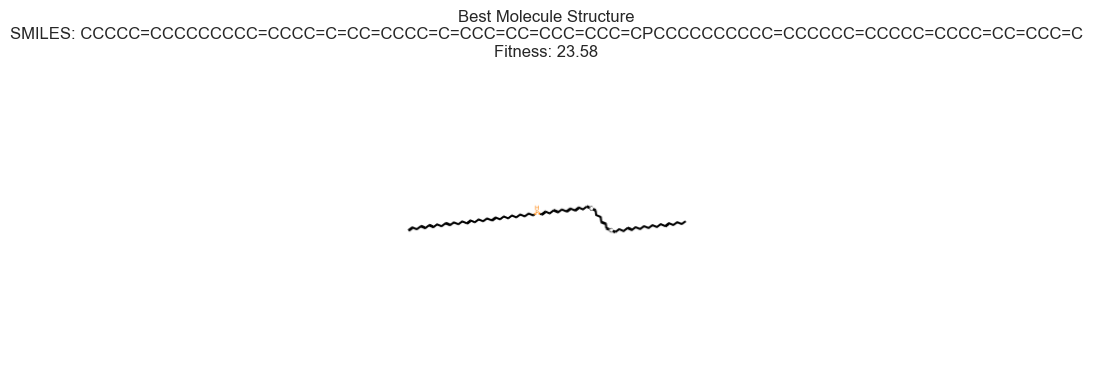

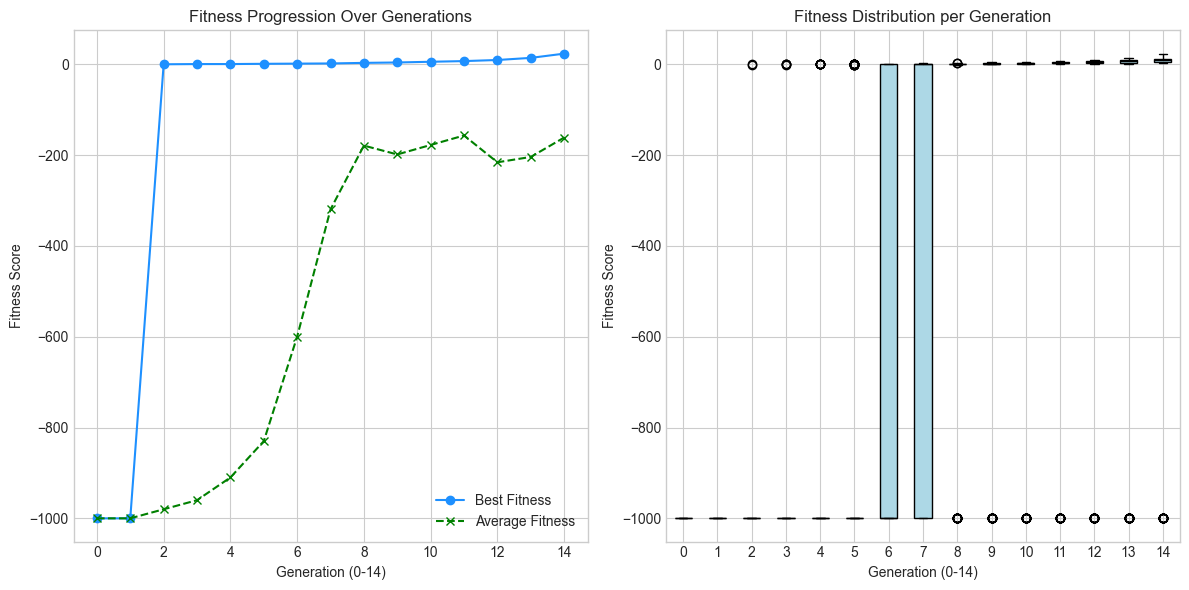

In [8]:
# --- GA Parameters ---
num_generations = 15
pop_size = 100
crossover_rate = 0.8
mutation_rate = 0.2 # Probability an individual is mutated
tournament_size = 5
elitism_count = 2
initial_pop = [generate_random_smiles(random.randint(10, 25)) for _ in range(pop_size)]

print("Starting Simple Genetic Algorithm for SMILES generation...")

results = simple_genetic_algorithm(
    initial_population=initial_pop,
    fitness_function=rdkit_logp_fitness,
    generations=num_generations,
    population_size=pop_size,
    crossover_rate=crossover_rate,
    mutation_rate=mutation_rate,
    tournament_size=tournament_size,
    elitism_count=elitism_count
)

print("\nGA Run Finished.")
print(f"Best SMILES found: {results['best_smiles']}")
print(f"Best Fitness score: {results['best_fitness']:.4f}")
plot_ga_results(results)


In [9]:
def rdkit_logp_fitness_2(smiles):
    """
    Calculates a fitness score based on LogP, molecular weight,
    ring presence, and connectivity for a given SMILES string using RDKit.
    Returns a very low score for invalid or highly undesirable SMILES.
    """
    if not smiles:
        return -1000.0 # Penalize empty SMILES

    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return -1000.0  # Invalid SMILES, return a very low fitness

    fitness_score = 0.0

    try:
        # 1. Base score from LogP
        fitness_score += Crippen.MolLogP(mol)

        # 2. Check for connected molecule
        frags = Chem.GetMolFrags(mol, asMols=False) # Get fragment indices
        if len(frags) > 1:
            fitness_score -= 100  # Heavy penalty for disconnected molecules

        # 3. Molecular weight constraint (< 500 Da)
        mw = Descriptors.MolWt(mol)
        if mw < 500:
            fitness_score += 10 # Bonus for being under 500 Da
        else:
            fitness_score -= (mw - 500) / 10 # Penalize proportionally for exceeding 500 Da

        # 4. Ring presence (at least one ring)
        if mol.GetRingInfo().NumRings() > 0:
            fitness_score += 10*mol.GetRingInfo().NumRings()   # Bonus for having at least one ring
        else:
            fitness_score -= 10   # Penalty for no rings
        
        return fitness_score
    except Exception: # Catch any other RDKit errors during calculation
        return -1000.0

In [10]:
# --- GA Parameters ---
num_generations = 100
pop_size = 100
crossover_rate = 0.8
mutation_rate = 0.2 # Probability an individual is mutated
tournament_size = 5
elitism_count = 2
initial_pop = [generate_random_smiles(random.randint(10, 25)) for _ in range(pop_size)]

print("Starting Simple Genetic Algorithm for SMILES generation...")

results = simple_genetic_algorithm(
    initial_population=initial_pop,
    fitness_function=rdkit_logp_fitness_2,
    generations=num_generations,
    population_size=pop_size,
    crossover_rate=crossover_rate,
    mutation_rate=mutation_rate,
    tournament_size=tournament_size,
    elitism_count=elitism_count
)

print("\nGA Run Finished.")
print(f"Best SMILES found: {results['best_smiles']}")
print(f"Best Fitness score: {results['best_fitness']:.4f}")
plot_ga_results(results)

Starting Simple Genetic Algorithm for SMILES generation...
Generation 1: New best -> Fitness: -1000.0000, SMILES: -#=o753BlCr57
Generation 2: Best this gen -> Fitness: -1000.0000, SMILES: -#=o753BlCr57
Generation 3: Best this gen -> Fitness: -1000.0000, SMILES: -#=o753BlCr57
Generation 4: Best this gen -> Fitness: -1000.0000, SMILES: -#=o753BlCr57
Generation 5: Best this gen -> Fitness: -1000.0000, SMILES: -#=o753BlCr57
Generation 6: New best -> Fitness: 0.5857, SMILES: FC
Generation 7: Best this gen -> Fitness: 0.5857, SMILES: FC
Generation 8: New best -> Fitness: 1.0838, SMILES: FCOCl
Generation 9: New best -> Fitness: 1.1522, SMILES: FCCl
Generation 10: New best -> Fitness: 1.5752, SMILES: ICl
Generation 11: New best -> Fitness: 1.9569, SMILES: CCCCOCl
Generation 12: Best this gen -> Fitness: 1.9569, SMILES: CCCCOCl
Generation 13: New best -> Fitness: 2.4919, SMILES: CCCICI
Generation 14: New best -> Fitness: 3.2887, SMILES: CCCCOCCCICI
Generation 15: New best -> Fitness: 4.9522, SM

KeyboardInterrupt: 

In [ ]:
def rdkit_qed_logp_fitness(smiles):
    """
    Calculates a fitness score based on LogP, QED (drug-likeness),
    molecular weight, ring presence, and connectivity.
    Higher QED (0-1) is better. QED is weighted by 10.
    Returns a very low score for invalid or highly undesirable SMILES.
    """
    if not smiles:
        return -1000.0

    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return -1000.0

    fitness_score = 0.0
    try:
        # 1. Base score from LogP
        fitness_score += Crippen.MolLogP(mol)

        # 2. Add QED score (weighted)
        qed_val = QED.qed(mol)
        fitness_score += qed_val * 10  # QED is 0-1, scale it up

        # 3. Check for connected molecule
        frags = Chem.GetMolFrags(mol, asMols=False)
        if len(frags) > 1:
            fitness_score -= 100  # Heavy penalty for disconnected molecules

        # 4. Molecular weight constraint (< 500 Da)
        mw = Descriptors.MolWt(mol)
        if mw < 500:
            fitness_score += 10 # Bonus
        else:
            fitness_score -= (mw - 500) / 10 # Penalize proportionally

        # 5. Ring presence (at least one ring)
        if mol.GetRingInfo().NumRings() > 0:
            fitness_score += 10*mol.GetRingInfo().NumRings()   # Bonus
        else:
            fitness_score -= 10   # Penalty
        
        return fitness_score
    except Exception:
        return -1000.0

In [ ]:
# --- GA Parameters ---
num_generations = 100
pop_size = 100
crossover_rate = 0.8
mutation_rate = 0.2 # Probability an individual is mutated
tournament_size = 5
elitism_count = 2
initial_pop = [generate_random_smiles(random.randint(10, 25)) for _ in range(pop_size)]

print("Starting Simple Genetic Algorithm for SMILES generation...")

results = simple_genetic_algorithm(
    initial_population=initial_pop,
    fitness_function=rdkit_qed_logp_fitness,
    generations=num_generations,
    population_size=pop_size,
    crossover_rate=crossover_rate,
    mutation_rate=mutation_rate,
    tournament_size=tournament_size,
    elitism_count=elitism_count
)

print("\nGA Run Finished.")
print(f"Best SMILES found: {results['best_smiles']}")
print(f"Best Fitness score: {results['best_fitness']:.4f}")
plot_ga_results(results)

In [ ]:
def rdkit_sa_qed_logp_fitness(smiles):
    """
    Calculates a fitness score based on LogP, QED, SAscore (synthetic accessibility),
    molecular weight, ring presence, and connectivity.
    Lower SAscore (1-10) is better. Term (5 - SAscore) * 2 is used.
    Returns a very low score for invalid or highly undesirable SMILES.
    """
    if not smiles:
        return -1000.0

    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return -1000.0

    fitness_score = 0.0
    try:
        logp_val = Crippen.MolLogP(mol)
        qed_val = QED.qed(mol)
        sa_val = sascorer.calculateScore(mol) # SAscore: 1 (easy) to 10 (hard)

        fitness_score = logp_val + (qed_val * 10) + ((5 - sa_val) * 2) # SA term: +8 to -10

        frags = Chem.GetMolFrags(mol, asMols=False)
        if len(frags) > 1: fitness_score -= 100
        
        mw = Descriptors.MolWt(mol)
        if mw < 500: fitness_score += 10
        else: fitness_score -= (mw - 500) / 10
        
        if mol.GetRingInfo().NumRings() > 0: 
            fitness_score += 10*mol.GetRingInfo().NumRings()   # Bonus
        else: 
            fitness_score -= 10
        return fitness_score
    except Exception:
        return -1000.0

In [ ]:
# --- GA Parameters ---
num_generations = 100
pop_size = 100
crossover_rate = 0.8
mutation_rate = 0.2 # Probability an individual is mutated
tournament_size = 5
elitism_count = 2
initial_pop = [generate_random_smiles(random.randint(10, 25)) for _ in range(pop_size)]

print("Starting Simple Genetic Algorithm for SMILES generation...")

results = simple_genetic_algorithm(
    initial_population=initial_pop,
    fitness_function=rdkit_sa_qed_logp_fitness,
    generations=num_generations,
    population_size=pop_size,
    crossover_rate=crossover_rate,
    mutation_rate=mutation_rate,
    tournament_size=tournament_size,
    elitism_count=elitism_count
)

print("\nGA Run Finished.")
print(f"Best SMILES found: {results['best_smiles']}")
print(f"Best Fitness score: {results['best_fitness']:.4f}")
plot_ga_results(results)

In [ ]:
sol_df = pd.read_tsv('Solubility_AqSolDB')
sol_df.head()
sol_df.rename(columns={"A": "Name", "B": "SMILES", "C": "LogS"}) # Thijs used ["Name","SMILES","LogS"]

property_names = list(rdMolDescriptors.Properties.GetAvailableProperties())
property_getter = rdMolDescriptors.Properties(property_names)

def smi2props(smi):
    mol = Chem.MolFromSmiles(smi)
    props = None
    if mol:
        #Chem.DeleteSubstructs(mol, Chem.MolFromSmarts("[#1X0]"))
        props = np.array(property_getter.ComputeProperties(mol))
    return props
sol_df['props'] = df.SMILES.progress_apply(smi2props)
sol_df[property_names] = sol_df['props'].to_list()
train, test = train_test_split(sol_df, random_state=42)
train_X = train[property_names]
train_y = train.LogS
test_X = test[property_names]
test_y = test.LogS
rf2 = RandomForestRegressor(max_depth=10, n_estimators=100, max_features=0.2, random_state=42)
# train the model
rf2.fit(train_X, train_y)
# predict
pred = rf2.predict(test_X)
